In [1]:
import json
import os,re

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from cswEngine import *
from cswMturk import *
from cswNets import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [83]:
path_L,RFC_L = Exp().gen_k_paths(1)

In [84]:
# keep names of nodes only
path_L2 = [[node.name for node in path if node.type == 'story_node'] for path in path_L]

# make path_L which is list of lists, into single long list
L = []
for path in path_L2:
  L.extend([n for n in path])

# form vocabulary 
S = set(L)
I = np.eye(len(S),dtype=np.float32)
vocab = {n:idx for idx,n in enumerate(S)}

# sequence of onehot vectors
vec_seq = np.array([I[vocab[st]] for st in L])
vec_seq.shape

(9, 9)

In [85]:
# vec_seq to train data X,Y
X,Y = [],[]
for x,y in zip(vec_seq[:-1],vec_seq[1:]):
  X.append(x)
  Y.append(y)
X = np.array(X)
Y = np.array(Y)

In [86]:
def get_layer(dims,lname):
  with tf.variable_scope('params_%s'%lname):
    W = tf.get_variable(name="weight",
                initializer=tf.contrib.layers.xavier_initializer(),
                shape=[dims[0],dims[1]])
    b = tf.get_variable(name="bias",
                initializer=tf.contrib.layers.xavier_initializer(),
                shape=[dims[1]])
  return W,b

def setup_inference(batch_x,layer_dims):
  A = batch_x
  for idx,layer_dim in enumerate(layer_dims[:-1]):
    W,b = get_layer(layer_dim,'lay%ito%i'%(idx,idx+1))
    with tf.variable_scope('layer%i'%idx):
      AW = tf.matmul(A,W)
      AWb = tf.nn.bias_add(AW,b,name='preact_%i'%idx)
      A = tf.nn.elu(AWb, name='act_%i'%idx)
  W,b = get_layer(layer_dims[-1],'lay_softmax')
  AW = tf.matmul(A,W)
  AWb = tf.nn.bias_add(AW,b,name='preact_%i'%idx)
  yhat = tf.nn.softmax(AWb)
  return yhat

In [87]:
X.shape

(8, 9)

In [94]:
layer_dims = [[X.shape[1],15],[15,15],[15,X.shape[1]]]

graph = tf.Graph()

# tf dataset
with graph.as_default():
  # dataset
  train_ds = tf.data.Dataset.from_tensor_slices((X,Y))
  train_ds = train_ds.repeat()
  train_ds = train_ds.shuffle(10000)
  train_ds = train_ds.apply(
    tf.contrib.data.batch_and_drop_remainder(1))
  # iterator
  itr = train_ds.make_one_shot_iterator()
  batch_x,batch_y = itr.get_next()
  # setup graph
  yhat = setup_inference(batch_x,layer_dims)
  # setup optimizer
  loss = tf.losses.softmax_cross_entropy(onehot_labels=batch_y,logits=yhat)
  train_op = tf.train.GradientDescentOptimizer(0.005).minimize(loss)
  # eval measures
  acc,acc_update = tf.metrics.accuracy(labels=tf.argmax(batch_y,0), 
                                       predictions=tf.argmax(yhat,0))
                                            

Lacc,Lloss = [],[]
with tf.Session(graph=graph) as sess:
  tf.global_variables_initializer().run()
  tf.local_variables_initializer().run()
  for i in range(1000):
    _,_,_acc,_loss,_y,_yh = sess.run([train_op,acc_update,acc,loss,batch_y,yhat])
    Lacc.append(_acc)
    Lloss.append(_loss)
    print()
    print(_y)
    print(_yh.round(2))
    




[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.08 0.14 0.08 0.22 0.06]]

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.07 0.07 0.21 0.06 0.11 0.13 0.09 0.19 0.07]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.1  0.08 0.15 0.14 0.07 0.18 0.07 0.16 0.04]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.07 0.21 0.06 0.08 0.09 0.11 0.25 0.08]]

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.07 0.06 0.21 0.05 0.06 0.1  0.11 0.27 0.06]]

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0.07 0.09 0.25 0.09 0.08 0.07 0.12 0.19 0.05]]

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.07 0.08 0.27 0.06 0.1  0.08 0.08 0.18 0.08]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.07 0.21 0.06 0.08 0.09 0.11 0.24 0.08]]

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.07 0.07 0.22 0.06 0.11 0.13 0.09 0.19 0.07]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.1  0.08 0.15 0.14 0.07 0.18 0.07 0.16 0.04]]

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0.07 0.09 0.25 0.09 0.08 0.07 0.12 0.19 0.05]]

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0.08 0.06 0.25 0.1  0.08 0.1  0.07 0.18 0.08]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0

[[0.1  0.08 0.16 0.14 0.07 0.19 0.08 0.15 0.04]]

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.07 0.08 0.28 0.06 0.1  0.08 0.08 0.16 0.08]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.1  0.08 0.16 0.14 0.07 0.19 0.08 0.15 0.04]]

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0.08 0.06 0.25 0.1  0.09 0.11 0.07 0.16 0.08]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.08 0.14 0.09 0.2  0.06]]

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.08 0.06 0.22 0.06 0.07 0.11 0.11 0.25 0.06]]

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0.07 0.09 0.27 0.09 0.08 0.07 0.12 0.17 0.05]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.08 0.14 0.09 0.2  0.06]]

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0.07 0.09 0.28 0.09 0.08 0.07 0.12 0.17 0.05]]

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.08 0.06 0.22 0.06 0.07 0.11 0.11 0.25 0.06]]

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.08 0.06 0.22 0.06 0.07 0.11 0.11 0.25 0.06]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.07 0.22 0.06 0.09 0.09 0.11 0.22 0.08]]

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0.07 0.08 0.28 0.09 0.08 0

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.07 0.22 0.06 0.09 0.1  0.11 0.2  0.08]]

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.07 0.07 0.22 0.06 0.12 0.14 0.1  0.16 0.08]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.09 0.15 0.09 0.19 0.06]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.07 0.22 0.06 0.09 0.1  0.11 0.2  0.08]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.09 0.15 0.09 0.19 0.06]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.09 0.15 0.09 0.19 0.06]]

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0.08 0.06 0.25 0.1  0.09 0.12 0.08 0.15 0.08]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.1  0.09 0.16 0.14 0.07 0.19 0.08 0.14 0.04]]

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.07 0.07 0.22 0.06 0.12 0.14 0.1  0.16 0.08]]

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0.08 0.06 0.25 0.1  0.09 0.12 0.08 0.15 0.08]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.09 0.15 0.1  0.19 0.06]]

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.07 0.08 0.27 0.06 0.11 0.08 0.09 0.15 0.08]]

[[0. 0. 0. 0. 1. 0. 0. 0. 0.


[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.07 0.07 0.22 0.06 0.12 0.14 0.1  0.15 0.08]]

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0.07 0.08 0.29 0.09 0.08 0.07 0.12 0.14 0.05]]

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.07 0.07 0.22 0.06 0.12 0.14 0.1  0.15 0.08]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.07 0.23 0.06 0.1  0.1  0.12 0.19 0.09]]

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0.07 0.08 0.29 0.09 0.08 0.07 0.12 0.14 0.05]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.07 0.23 0.06 0.1  0.1  0.12 0.19 0.09]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.07 0.23 0.06 0.1  0.1  0.12 0.19 0.09]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.19 0.09 0.09 0.15 0.1  0.17 0.07]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.1  0.09 0.16 0.14 0.07 0.19 0.08 0.13 0.04]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.1  0.09 0.16 0.14 0.07 0.19 0.08 0.13 0.04]]

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.07 0.08 0.28 0.06 0.12 0.09 0.09 0.14 0.08]]

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.07 0.08 0.28 0.06 0.12 0.09 0.09 0.14 0.08]]

[[1. 0. 0. 0. 0. 0. 0. 0. 0

[[0.07 0.08 0.31 0.08 0.09 0.07 0.12 0.13 0.05]]

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0.06 0.06 0.23 0.06 0.1  0.1  0.12 0.17 0.09]]

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0.08 0.06 0.24 0.09 0.1  0.15 0.08 0.12 0.08]]

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.07 0.08 0.28 0.06 0.13 0.09 0.09 0.12 0.08]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.1  0.09 0.16 0.13 0.08 0.2  0.08 0.12 0.04]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.1  0.15 0.1  0.16 0.07]]

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0.08 0.06 0.24 0.09 0.1  0.15 0.08 0.12 0.08]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.1  0.09 0.16 0.13 0.08 0.2  0.08 0.12 0.04]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.1  0.15 0.1  0.16 0.07]]

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.06 0.07 0.22 0.06 0.13 0.15 0.1  0.13 0.08]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.1  0.15 0.1  0.16 0.07]]

[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.07 0.08 0.18 0.09 0.1  0.15 0.1  0.16 0.07]]

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
[[0.08 0.06 0.24 0.09 0.1  0

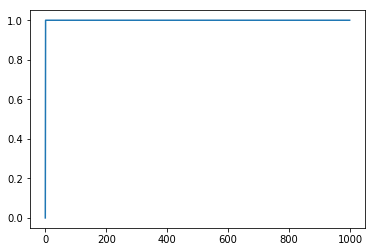

In [96]:
plt.plot(Lacc)

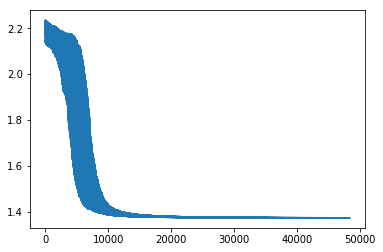

In [92]:
plt.plot(Lloss)
